# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-random'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend(random_indices)
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5827, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4929, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4691, Accuracy: 0.8166, F1 Micro: 0.2541, F1 Macro: 0.1855
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3982, Accuracy: 0.8419, F1 Micro: 0.4805, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3683, Accuracy: 0.8536, F1 Micro: 0.551, F1 Macro: 0.4992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2982, Accuracy: 0.8619, F1 Micro: 0.6173, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2597, Accuracy: 0.868, F1 Micro: 0.6793, F1 Macro: 0.6649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2216, Accuracy: 0.8684, F1 Micro: 0.6879, F1 Macro: 0.6795
Epoch 9/10, Train Loss: 0.1827, Accuracy: 0.873, F1 Micro: 0.6813, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.7881, F1 Micro: 0.0131, F1 Macro: 0.0119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.8253, F1 Micro: 0.3216, F1 Macro: 0.2118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3446, Accuracy: 0.8531, F1 Micro: 0.5323, F1 Macro: 0.4567
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2642, Accuracy: 0.873, F1 Micro: 0.6661, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2254, Accuracy: 0.877, F1 Micro: 0.6672, F1 Macro: 0.6374
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1805, Accuracy: 0.8813, F1 Micro: 0.702, F1 Macro: 0.6887
Epoch 7/10, Train Loss: 0.1396, Accuracy: 0.8827, F1 Micro: 0.6875, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1094, Accuracy: 0.8841, F1 Micro: 0.7142, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.8844, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4951, Accuracy: 0.8205, F1 Micro: 0.2751, F1 Macro: 0.1852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3531, Accuracy: 0.8553, F1 Micro: 0.5479, F1 Macro: 0.4981
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2773, Accuracy: 0.8781, F1 Micro: 0.688, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2284, Accuracy: 0.8844, F1 Micro: 0.7307, F1 Macro: 0.7223
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.8828, F1 Micro: 0.6693, F1 Macro: 0.6403
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1538, Accuracy: 0.8883, F1 Micro: 0.7333, F1 Macro: 0.7226
Epoch 7/10, Train Loss: 0.1209, Accuracy: 0.8902, F1 Micro: 0.7312, F1 Macro: 0.7188
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0872, Accuracy: 0.8892, F1 Micro: 0.7379, F1 Macro: 0.7296
Epoch 9/10, Train Loss: 0.0736, Accuracy: 0.887, F1 Micro: 0.7033, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4719, Accuracy: 0.832, F1 Micro: 0.3768, F1 Macro: 0.2903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3382, Accuracy: 0.872, F1 Micro: 0.6534, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2737, Accuracy: 0.8858, F1 Micro: 0.7319, F1 Macro: 0.7248
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2188, Accuracy: 0.8939, F1 Micro: 0.7446, F1 Macro: 0.7336
Epoch 5/10, Train Loss: 0.1734, Accuracy: 0.8919, F1 Micro: 0.7359, F1 Macro: 0.7227
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.8911, F1 Micro: 0.7285, F1 Macro: 0.7176
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.8925, F1 Micro: 0.7337, F1 Macro: 0.7163
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.8953, F1 Micro: 0.7509, F1 Macro: 0.7462
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.8922, F1 Micro: 0.7342, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.8919, F1 Micro: 0.7265, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4444, Accuracy: 0.8305, F1 Micro: 0.3636, F1 Macro: 0.2665
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2993, Accuracy: 0.8783, F1 Micro: 0.7035, F1 Macro: 0.6961
Epoch 3/10, Train Loss: 0.2371, Accuracy: 0.8856, F1 Micro: 0.6975, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2002, Accuracy: 0.8945, F1 Micro: 0.7318, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.8923, F1 Micro: 0.7351, F1 Macro: 0.7231
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1201, Accuracy: 0.8942, F1 Micro: 0.7488, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8913, F1 Micro: 0.7636, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.0759, Accuracy: 0.8956, F1 Micro: 0.7491, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.898, F1 Micro: 0.7654, F1 Macro: 0.7618
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4404, Accuracy: 0.8473, F1 Micro: 0.4956, F1 Macro: 0.4332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2926, Accuracy: 0.8842, F1 Micro: 0.7016, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.8905, F1 Micro: 0.717, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1963, Accuracy: 0.8973, F1 Micro: 0.7509, F1 Macro: 0.7447
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.8847, F1 Micro: 0.68, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1261, Accuracy: 0.8938, F1 Micro: 0.7701, F1 Macro: 0.7678
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.8941, F1 Micro: 0.7259, F1 Macro: 0.7063
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.8981, F1 Micro: 0.7658, F1 Macro: 0.7576
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.8977, F1 Micro: 0.7603, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.897, F1 Micro: 0.7625, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4393, Accuracy: 0.8523, F1 Micro: 0.5441, F1 Macro: 0.5012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.8884, F1 Micro: 0.7226, F1 Macro: 0.7155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.8948, F1 Micro: 0.7274, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.9025, F1 Micro: 0.7697, F1 Macro: 0.763
Epoch 5/10, Train Loss: 0.135, Accuracy: 0.8994, F1 Micro: 0.7549, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.9003, F1 Micro: 0.7698, F1 Macro: 0.7669
Epoch 7/10, Train Loss: 0.0822, Accuracy: 0.9006, F1 Micro: 0.7611, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.8972, F1 Micro: 0.7592, F1 Macro: 0.7503
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.8995, F1 Micro: 0.7676, F1 Macro: 0.7618
Epoch 10/10, Train Loss: 0.0369, Accuracy: 0.8986, F1 Micro: 0.769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4296, Accuracy: 0.8602, F1 Micro: 0.5687, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8914, F1 Micro: 0.7472, F1 Macro: 0.7411
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.8925, F1 Micro: 0.736, F1 Macro: 0.7321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1793, Accuracy: 0.9003, F1 Micro: 0.7609, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1416, Accuracy: 0.8978, F1 Micro: 0.7691, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.8995, F1 Micro: 0.7759, F1 Macro: 0.774
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.8983, F1 Micro: 0.7501, F1 Macro: 0.7365
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9002, F1 Micro: 0.766, F1 Macro: 0.7626
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8992, F1 Micro: 0.7686, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.898, F1 Micro: 0.7638, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.424, Accuracy: 0.8697, F1 Micro: 0.6599, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.895, F1 Micro: 0.7411, F1 Macro: 0.7369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2172, Accuracy: 0.8927, F1 Micro: 0.7654, F1 Macro: 0.762
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.898, F1 Micro: 0.7529, F1 Macro: 0.7475
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.8995, F1 Micro: 0.7584, F1 Macro: 0.7408
Epoch 6/10, Train Loss: 0.1047, Accuracy: 0.8958, F1 Micro: 0.7505, F1 Macro: 0.7403
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9005, F1 Micro: 0.7624, F1 Macro: 0.7556
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8964, F1 Micro: 0.7726, F1 Macro: 0.7718
Epoch 9/10, Train Loss: 0.0458, Accuracy: 0.898, F1 Micro: 0.7643, F1 Macro: 0.7571
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.8948, F1 Micro: 0.7701, F1 Macro: 0.769
Iteration 3711: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8741, F1 Micro: 0.6876, F1 Macro: 0.6824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2605, Accuracy: 0.8923, F1 Micro: 0.7413, F1 Macro: 0.7287
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.8963, F1 Micro: 0.7307, F1 Macro: 0.7112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.174, Accuracy: 0.8986, F1 Micro: 0.752, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.8964, F1 Micro: 0.7673, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9016, F1 Micro: 0.7558, F1 Macro: 0.7416
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.8994, F1 Micro: 0.7624, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9008, F1 Micro: 0.7661, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9017, F1 Micro: 0.7572, F1 Macro: 0.7482
Epoch 10/10, Train Loss: 0.0404, Accuracy: 0.8975, F1 Micro: 0.7609, F1 Macro: 0.7513
Iteration 3886: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4005, Accuracy: 0.8736, F1 Micro: 0.6868, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2643, Accuracy: 0.8911, F1 Micro: 0.7211, F1 Macro: 0.703
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.7667
Epoch 4/10, Train Loss: 0.1782, Accuracy: 0.9003, F1 Micro: 0.7678, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.9006, F1 Micro: 0.7727, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.1019, Accuracy: 0.8988, F1 Micro: 0.7656, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9002, F1 Micro: 0.7475, F1 Macro: 0.7326
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.8975, F1 Micro: 0.7604, F1 Macro: 0.7482
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9003, F1 Micro: 0.7708, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.8994, F1 Micro: 0.7702, F1 Macro: 0.7659
Iteration 4120: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4081, Accuracy: 0.8727, F1 Micro: 0.6667, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.8952, F1 Micro: 0.7495, F1 Macro: 0.7385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.8994, F1 Micro: 0.7581, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9002, F1 Micro: 0.7779, F1 Macro: 0.7762
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9016, F1 Micro: 0.7661, F1 Macro: 0.758
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9013, F1 Micro: 0.7718, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.8983, F1 Micro: 0.7654, F1 Macro: 0.7605
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9027, F1 Micro: 0.761, F1 Macro: 0.7505
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.8969, F1 Micro: 0.7692, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9008, F1 Micro: 0.7762, F1 Macro: 0.776
Iteration 4330: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3926, Accuracy: 0.8759, F1 Micro: 0.6772, F1 Macro: 0.6577
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.8931, F1 Micro: 0.7266, F1 Macro: 0.7063
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2048, Accuracy: 0.8952, F1 Micro: 0.7434, F1 Macro: 0.7437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9023, F1 Micro: 0.7653, F1 Macro: 0.7601
Epoch 5/10, Train Loss: 0.1364, Accuracy: 0.9011, F1 Micro: 0.7596, F1 Macro: 0.7487
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9014, F1 Micro: 0.7623, F1 Macro: 0.7506
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9002, F1 Micro: 0.7613, F1 Macro: 0.7538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0509, Accuracy: 0.902, F1 Micro: 0.7697, F1 Macro: 0.7649
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.8994, F1 Micro: 0.7677, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0342, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8795, F1 Micro: 0.6996, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.8986, F1 Micro: 0.7594, F1 Macro: 0.7486
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.8975, F1 Micro: 0.7489, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.8983, F1 Micro: 0.7609, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.8995, F1 Micro: 0.7745, F1 Macro: 0.7737
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.8984, F1 Micro: 0.7551, F1 Macro: 0.7494
Epoch 7/10, Train Loss: 0.0691, Accuracy: 0.8998, F1 Micro: 0.7677, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9006, F1 Micro: 0.7716, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.037, Accuracy: 0.8984, F1 Micro: 0.7645, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9005, F1 Micro: 0.7775, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3894, Accuracy: 0.88, F1 Micro: 0.7002, F1 Macro: 0.6979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.8953, F1 Micro: 0.7557, F1 Macro: 0.7446
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.8959, F1 Micro: 0.7321, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1733, Accuracy: 0.9025, F1 Micro: 0.7699, F1 Macro: 0.7614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.8998, F1 Micro: 0.77, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.8988, F1 Micro: 0.7674, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9006, F1 Micro: 0.7687, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.9008, F1 Micro: 0.7731, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.8988, F1 Micro: 0.7707, F1 Macro: 0.7695
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.8952, F1 Micro: 0.7668, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8811, F1 Micro: 0.7262, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2436, Accuracy: 0.8995, F1 Micro: 0.7734, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1958, Accuracy: 0.9038, F1 Micro: 0.7805, F1 Macro: 0.7787
Epoch 4/10, Train Loss: 0.1637, Accuracy: 0.8967, F1 Micro: 0.7797, F1 Macro: 0.7849
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.8988, F1 Micro: 0.7713, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9005, F1 Micro: 0.7719, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9036, F1 Micro: 0.7734, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9, F1 Micro: 0.7698, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9016, F1 Micro: 0.7661, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.8966, F1 Micro: 0.7554, F1 Macro: 0.7503
Iteration 5063: Accuracy: 0.9038, F1 Micro: 0.7805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3788, Accuracy: 0.8828, F1 Micro: 0.7193, F1 Macro: 0.7166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.8992, F1 Micro: 0.7691, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9048, F1 Micro: 0.7704, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.167, Accuracy: 0.9014, F1 Micro: 0.7766, F1 Macro: 0.7685
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9034, F1 Micro: 0.7756, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.8981, F1 Micro: 0.7761, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.902, F1 Micro: 0.7709, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9023, F1 Micro: 0.7838, F1 Macro: 0.7831
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9011, F1 Micro: 0.7694, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.8998, F1 Micro: 0.7733, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8823, F1 Micro: 0.7055, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.898, F1 Micro: 0.7649, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7651
Epoch 4/10, Train Loss: 0.1557, Accuracy: 0.905, F1 Micro: 0.7631, F1 Macro: 0.7461
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9041, F1 Micro: 0.7629, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.9058, F1 Micro: 0.7741, F1 Macro: 0.7661
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9025, F1 Micro: 0.7629, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9075, F1 Micro: 0.7698, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.8978, F1 Micro: 0.7749, F1 Macro: 0.7727
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.8981, F1 Micro: 0.7725, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.8848, F1 Micro: 0.7142, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2475, Accuracy: 0.8998, F1 Micro: 0.7625, F1 Macro: 0.7569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9062, F1 Micro: 0.7812, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9031, F1 Micro: 0.784, F1 Macro: 0.7831
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9042, F1 Micro: 0.7805, F1 Macro: 0.7788
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9039, F1 Micro: 0.7807, F1 Macro: 0.7793
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9025, F1 Micro: 0.7568, F1 Macro: 0.7492
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9023, F1 Micro: 0.7814, F1 Macro: 0.7812
Epoch 9/10, Train Loss: 0.0407, Accuracy: 0.9031, F1 Micro: 0.7667, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9075, F1 Micro: 0.7832, F1 Macro: 0.7793
Iteration 5641: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8864, F1 Micro: 0.7207, F1 Macro: 0.7074
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.8992, F1 Micro: 0.7621, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.902, F1 Micro: 0.7801, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.8998, F1 Micro: 0.782, F1 Macro: 0.7785
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9048, F1 Micro: 0.7783, F1 Macro: 0.7737
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9047, F1 Micro: 0.7752, F1 Macro: 0.7715
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9033, F1 Micro: 0.78, F1 Macro: 0.7804
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9039, F1 Micro: 0.7763, F1 Macro: 0.7741
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.902, F1 Micro: 0.7734, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.897, F1 Micro: 0.7709, F1 Macro: 0.7691
Iteration 5841: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8814, F1 Micro: 0.6744, F1 Macro: 0.6338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.9017, F1 Micro: 0.7532, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9064, F1 Micro: 0.7782, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1591, Accuracy: 0.9066, F1 Micro: 0.7805, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9042, F1 Micro: 0.7871, F1 Macro: 0.787
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9047, F1 Micro: 0.7747, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9041, F1 Micro: 0.7777, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9025, F1 Micro: 0.776, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9055, F1 Micro: 0.7728, F1 Macro: 0.764
Epoch 10/10, Train Loss: 0.0336, Accuracy: 0.9033, F1 Micro: 0.7801, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3628, Accuracy: 0.8892, F1 Micro: 0.727, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.8958, F1 Micro: 0.7646, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9022, F1 Micro: 0.7805, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.9013, F1 Micro: 0.7816, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9048, F1 Micro: 0.7846, F1 Macro: 0.7804
Epoch 6/10, Train Loss: 0.0833, Accuracy: 0.9069, F1 Micro: 0.7793, F1 Macro: 0.7746
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.902, F1 Micro: 0.7769, F1 Macro: 0.7766
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9038, F1 Micro: 0.7779, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9028, F1 Micro: 0.7751, F1 Macro: 0.7692
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9081, F1 Micro: 0.7754, F1 Ma

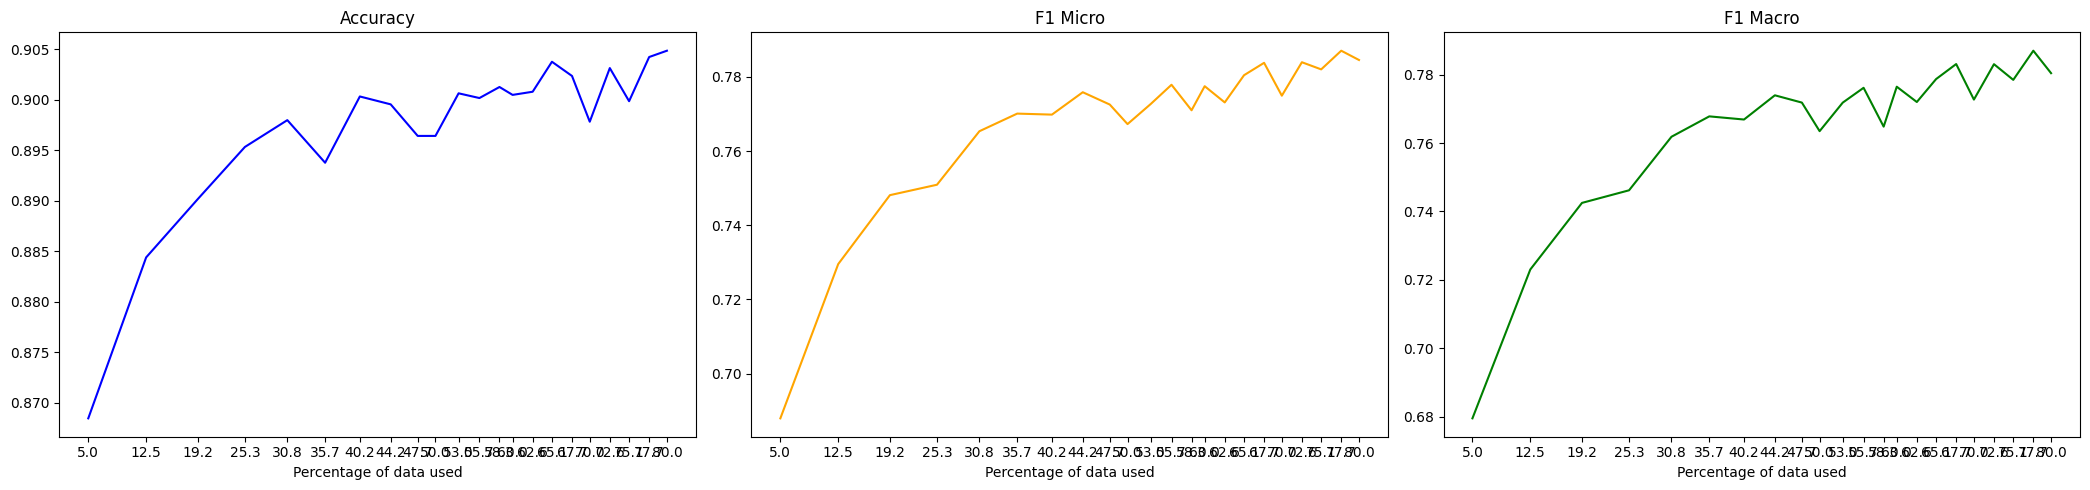

In [ ]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5994, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4993, Accuracy: 0.7959, F1 Micro: 0.0829, F1 Macro: 0.0688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4403, Accuracy: 0.8245, F1 Micro: 0.3072, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4234, Accuracy: 0.8428, F1 Micro: 0.4672, F1 Macro: 0.3892
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3468, Accuracy: 0.847, F1 Micro: 0.4972, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8569, F1 Micro: 0.5743, F1 Macro: 0.4944
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2813, Accuracy: 0.8633, F1 Micro: 0.6167, F1 Macro: 0.5671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2386, Accuracy: 0.8723, F1 Micro: 0.6669, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1873,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5496, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4176, Accuracy: 0.8462, F1 Micro: 0.5114, F1 Macro: 0.4076
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3362, Accuracy: 0.86, F1 Micro: 0.5863, F1 Macro: 0.5423
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2698, Accuracy: 0.877, F1 Micro: 0.6915, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.22, Accuracy: 0.8825, F1 Micro: 0.7009, F1 Macro: 0.6974
Epoch 6/10, Train Loss: 0.1696, Accuracy: 0.8784, F1 Micro: 0.6692, F1 Macro: 0.6481
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.8823, F1 Micro: 0.6992, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1083, Accuracy: 0.8842, F1 Micro: 0.712, F1 Macro: 0.7074
Epoch 9/10, Train Loss: 0.0881, Accuracy: 0.8819, F1 Micro: 0.6891, F1 Macro: 0.6813
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5082, Accuracy: 0.828, F1 Micro: 0.3443, F1 Macro: 0.2559
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3596, Accuracy: 0.8739, F1 Micro: 0.6556, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2679, Accuracy: 0.8788, F1 Micro: 0.7124, F1 Macro: 0.7113
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.8841, F1 Micro: 0.7013, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.8852, F1 Micro: 0.7459, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.8891, F1 Micro: 0.7237, F1 Macro: 0.7044
Epoch 7/10, Train Loss: 0.1089, Accuracy: 0.888, F1 Micro: 0.7382, F1 Macro: 0.7365
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.8895, F1 Micro: 0.72, F1 Macro: 0.7084
Epoch 9/10, Train Loss: 0.0612, Accuracy: 0.8875, F1 Micro: 0.7209, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.049, Accuracy: 0.8886, F1 Micro: 0.7492, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8455, F1 Micro: 0.483, F1 Macro: 0.4124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3147, Accuracy: 0.8786, F1 Micro: 0.6799, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.8886, F1 Micro: 0.7517, F1 Macro: 0.7517
Epoch 4/10, Train Loss: 0.1958, Accuracy: 0.8927, F1 Micro: 0.7464, F1 Macro: 0.7401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1591, Accuracy: 0.8959, F1 Micro: 0.766, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.8936, F1 Micro: 0.7419, F1 Macro: 0.7334
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.8888, F1 Micro: 0.7593, F1 Macro: 0.763
Epoch 8/10, Train Loss: 0.072, Accuracy: 0.8961, F1 Micro: 0.7572, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.8956, F1 Micro: 0.7562, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0477, Accuracy: 0.8983, F1 Micro: 0.7674, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4606, Accuracy: 0.8475, F1 Micro: 0.4847, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3026, Accuracy: 0.887, F1 Micro: 0.7125, F1 Macro: 0.7078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2347, Accuracy: 0.8939, F1 Micro: 0.759, F1 Macro: 0.7573
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.8972, F1 Micro: 0.7541, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1599, Accuracy: 0.8973, F1 Micro: 0.7684, F1 Macro: 0.7666
Epoch 6/10, Train Loss: 0.119, Accuracy: 0.8972, F1 Micro: 0.7471, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0919, Accuracy: 0.8975, F1 Micro: 0.7758, F1 Macro: 0.7717
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.8989, F1 Micro: 0.7601, F1 Macro: 0.7533
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.8998, F1 Micro: 0.7703, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.8975, F1 Micro: 0.764, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.454, Accuracy: 0.8698, F1 Micro: 0.6454, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.8816, F1 Micro: 0.6741, F1 Macro: 0.6435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.8991, F1 Micro: 0.7437, F1 Macro: 0.7325
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9008, F1 Micro: 0.7566, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.8969, F1 Micro: 0.7668, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1121, Accuracy: 0.8997, F1 Micro: 0.7746, F1 Macro: 0.7723
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.8869, F1 Micro: 0.7618, F1 Macro: 0.7605
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.8948, F1 Micro: 0.7432, F1 Macro: 0.7323
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9, F1 Micro: 0.7656, F1 Macro: 0.7615
Epoch 10/10, Train Loss: 0.0418, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4362, Accuracy: 0.8709, F1 Micro: 0.6371, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.8913, F1 Micro: 0.7507, F1 Macro: 0.7465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.8969, F1 Micro: 0.7508, F1 Macro: 0.7472
Epoch 4/10, Train Loss: 0.1833, Accuracy: 0.8981, F1 Micro: 0.7415, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.8998, F1 Micro: 0.7614, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.8975, F1 Micro: 0.7685, F1 Macro: 0.7641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.8973, F1 Micro: 0.7745, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8994, F1 Micro: 0.7502, F1 Macro: 0.7379
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9023, F1 Micro: 0.7649, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0332, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4232, Accuracy: 0.8741, F1 Micro: 0.6683, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2712, Accuracy: 0.892, F1 Micro: 0.7362, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.9009, F1 Micro: 0.7683, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9006, F1 Micro: 0.7729, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.898, F1 Micro: 0.759, F1 Macro: 0.7543
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.8911, F1 Micro: 0.7691, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.8994, F1 Micro: 0.7698, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9058, F1 Micro: 0.7781, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.8998, F1 Micro: 0.7655, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9047, F1 Micro: 0.7698, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4162, Accuracy: 0.8794, F1 Micro: 0.7008, F1 Macro: 0.6855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.8928, F1 Micro: 0.7621, F1 Macro: 0.7637
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9017, F1 Micro: 0.7555, F1 Macro: 0.7508
Epoch 4/10, Train Loss: 0.1673, Accuracy: 0.8995, F1 Micro: 0.7503, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.8997, F1 Micro: 0.771, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9002, F1 Micro: 0.7799, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.8998, F1 Micro: 0.7672, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9022, F1 Micro: 0.7616, F1 Macro: 0.7566
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9017, F1 Micro: 0.7733, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.897, F1 Micro: 0.7671, F1 Macro: 0.7638
Iteration 3711: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4109, Accuracy: 0.8788, F1 Micro: 0.7081, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2518, Accuracy: 0.8984, F1 Micro: 0.7538, F1 Macro: 0.7431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.9041, F1 Micro: 0.7801, F1 Macro: 0.7772
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.8952, F1 Micro: 0.7717, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9, F1 Micro: 0.7686, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.8938, F1 Micro: 0.7668, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9002, F1 Micro: 0.7562, F1 Macro: 0.7528
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9005, F1 Micro: 0.7679, F1 Macro: 0.7635
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9038, F1 Micro: 0.7649, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.9033, F1 Micro: 0.7679, F1 Macro: 0.7648
Iteration 3886: Accuracy: 0.9041, F1 Micro: 0.7801, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3949, Accuracy: 0.8797, F1 Micro: 0.6915, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2523, Accuracy: 0.8956, F1 Micro: 0.7362, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2028, Accuracy: 0.9041, F1 Micro: 0.7512, F1 Macro: 0.739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9023, F1 Micro: 0.7749, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9025, F1 Micro: 0.7728, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9016, F1 Micro: 0.7783, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.902, F1 Micro: 0.7699, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0506, Accuracy: 0.9014, F1 Micro: 0.7603, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9042, F1 Micro: 0.7725, F1 Macro: 0.7707
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.905, F1 Micro: 0.773, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8789, F1 Micro: 0.6523, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2562, Accuracy: 0.8941, F1 Micro: 0.7621, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9016, F1 Micro: 0.7658, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9048, F1 Micro: 0.7773, F1 Macro: 0.7726
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.8997, F1 Micro: 0.7629, F1 Macro: 0.7557
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.8967, F1 Micro: 0.7718, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9008, F1 Micro: 0.768, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.8963, F1 Micro: 0.7779, F1 Macro: 0.7797
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9038, F1 Micro: 0.7749, F1 Macro: 0.7722
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9014, F1 Micro: 0.772, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8823, F1 Micro: 0.7109, F1 Macro: 0.7022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.8992, F1 Micro: 0.7563, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2011, Accuracy: 0.9019, F1 Micro: 0.7828, F1 Macro: 0.7819
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9047, F1 Micro: 0.7705, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9005, F1 Micro: 0.7731, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.898, F1 Micro: 0.7755, F1 Macro: 0.7768
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.9023, F1 Micro: 0.7535, F1 Macro: 0.7445
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9034, F1 Micro: 0.7696, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9011, F1 Micro: 0.7738, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.9027, F1 Micro: 0.7687, F1 Macro: 0.7657
Iteration 4530: Accuracy: 0.9019, F1 Micro: 0.7828, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3967, Accuracy: 0.8795, F1 Micro: 0.6675, F1 Macro: 0.6547
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.903, F1 Micro: 0.7752, F1 Macro: 0.7702
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9013, F1 Micro: 0.7732, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1602, Accuracy: 0.9042, F1 Micro: 0.7741, F1 Macro: 0.7712
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.902, F1 Micro: 0.7582, F1 Macro: 0.7423
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9014, F1 Micro: 0.7679, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.8994, F1 Micro: 0.7459, F1 Macro: 0.7307
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9014, F1 Micro: 0.7526, F1 Macro: 0.7443
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.9008, F1 Micro: 0.773, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9009, F1 Micro: 0.7745, F1 Macro: 0.774
Iteration 4663: Accuracy: 0.903, F1 Micro: 0.7752, F1 Macro: 0.7702
                   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3795, Accuracy: 0.8809, F1 Micro: 0.6796, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.898, F1 Micro: 0.7761, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1945, Accuracy: 0.9023, F1 Micro: 0.78, F1 Macro: 0.7789
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9044, F1 Micro: 0.7666, F1 Macro: 0.7578
Epoch 5/10, Train Loss: 0.1121, Accuracy: 0.8995, F1 Micro: 0.776, F1 Macro: 0.7733
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9002, F1 Micro: 0.7696, F1 Macro: 0.7666
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9039, F1 Micro: 0.7682, F1 Macro: 0.7612
Epoch 8/10, Train Loss: 0.0512, Accuracy: 0.9031, F1 Micro: 0.7745, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9053, F1 Micro: 0.7792, F1 Macro: 0.7781
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9033, F1 Micro: 0.7774, F1 Macro: 0.7772
Iteration 4863: Accuracy: 0.9023, F1 Micro: 0.78, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.885, F1 Micro: 0.6822, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2454, Accuracy: 0.8991, F1 Micro: 0.7609, F1 Macro: 0.7612
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9009, F1 Micro: 0.7516, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9031, F1 Micro: 0.7754, F1 Macro: 0.7699
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.902, F1 Micro: 0.7638, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9042, F1 Micro: 0.7811, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9055, F1 Micro: 0.7846, F1 Macro: 0.7844
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9052, F1 Micro: 0.7734, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.902, F1 Micro: 0.7732, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9023, F1 Micro: 0.7784, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.8789, F1 Micro: 0.7345, F1 Macro: 0.7378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2406, Accuracy: 0.8978, F1 Micro: 0.7578, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9022, F1 Micro: 0.7766, F1 Macro: 0.7725
Epoch 4/10, Train Loss: 0.1655, Accuracy: 0.9009, F1 Micro: 0.7744, F1 Macro: 0.7742
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9025, F1 Micro: 0.7729, F1 Macro: 0.7666
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9019, F1 Micro: 0.7689, F1 Macro: 0.7625
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9055, F1 Micro: 0.7758, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9019, F1 Micro: 0.7782, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.8994, F1 Micro: 0.7737, F1 Macro: 0.7711
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.9041, F1 Micro: 0.7704, F1 Macro: 0.7688
Iteration 5263: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8903, F1 Micro: 0.7355, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9011, F1 Micro: 0.7745, F1 Macro: 0.7727
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9055, F1 Micro: 0.7735, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1611, Accuracy: 0.9044, F1 Micro: 0.7787, F1 Macro: 0.7747
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9047, F1 Micro: 0.7744, F1 Macro: 0.7702
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.8992, F1 Micro: 0.7728, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0668, Accuracy: 0.9053, F1 Micro: 0.7801, F1 Macro: 0.7781
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7726
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.9069, F1 Micro: 0.7801, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0284, Accuracy: 0.903, F1 Micro: 0.7726, F1 Macro: 0.7708
Iteration 5441: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8889, F1 Micro: 0.7497, F1 Macro: 0.7472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8998, F1 Micro: 0.7697, F1 Macro: 0.7676
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.8977, F1 Micro: 0.7347, F1 Macro: 0.7143
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9022, F1 Micro: 0.7537, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9069, F1 Micro: 0.7842, F1 Macro: 0.7817
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.8963, F1 Micro: 0.7763, F1 Macro: 0.7758
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9059, F1 Micro: 0.783, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9033, F1 Micro: 0.7695, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9028, F1 Micro: 0.7705, F1 Macro: 0.7667
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.902, F1 Micro: 0.7768, F1 Macro: 0.7759
Iteration 5641: Accuracy: 0.9069, F1 Micro: 0.7842, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.8894, F1 Micro: 0.741, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2245, Accuracy: 0.9019, F1 Micro: 0.7689, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1867, Accuracy: 0.9042, F1 Micro: 0.7804, F1 Macro: 0.7698
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9036, F1 Micro: 0.7773, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9023, F1 Micro: 0.7832, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0838, Accuracy: 0.9086, F1 Micro: 0.7904, F1 Macro: 0.789
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9045, F1 Micro: 0.7776, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9067, F1 Micro: 0.7849, F1 Macro: 0.7845
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9053, F1 Micro: 0.7853, F1 Macro: 0.787
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.9048, F1 Micro: 0.7824, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8909, F1 Micro: 0.7292, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9003, F1 Micro: 0.7765, F1 Macro: 0.7758
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9058, F1 Micro: 0.7865, F1 Macro: 0.7814
Epoch 4/10, Train Loss: 0.1581, Accuracy: 0.8998, F1 Micro: 0.7792, F1 Macro: 0.78
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9055, F1 Micro: 0.7733, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0842, Accuracy: 0.903, F1 Micro: 0.781, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9045, F1 Micro: 0.7672, F1 Macro: 0.7602
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9014, F1 Micro: 0.7762, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9038, F1 Micro: 0.7816, F1 Macro: 0.7805
Epoch 10/10, Train Loss: 0.028, Accuracy: 0.9034, F1 Micro: 0.7731, F1 Macro: 0.77
Iteration 6041: Accuracy: 0.9058, F1 Micro: 0.7865, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.357, Accuracy: 0.8895, F1 Micro: 0.7531, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2366, Accuracy: 0.9023, F1 Micro: 0.7814, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1923, Accuracy: 0.9055, F1 Micro: 0.782, F1 Macro: 0.7789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9059, F1 Micro: 0.7845, F1 Macro: 0.7807
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9033, F1 Micro: 0.7681, F1 Macro: 0.764
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9042, F1 Micro: 0.783, F1 Macro: 0.7839
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9031, F1 Micro: 0.7877, F1 Macro: 0.7916
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9044, F1 Micro: 0.7844, F1 Macro: 0.7805
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9027, F1 Micro: 0.7829, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.902, F1 Micro: 0.7865, F1 Mac

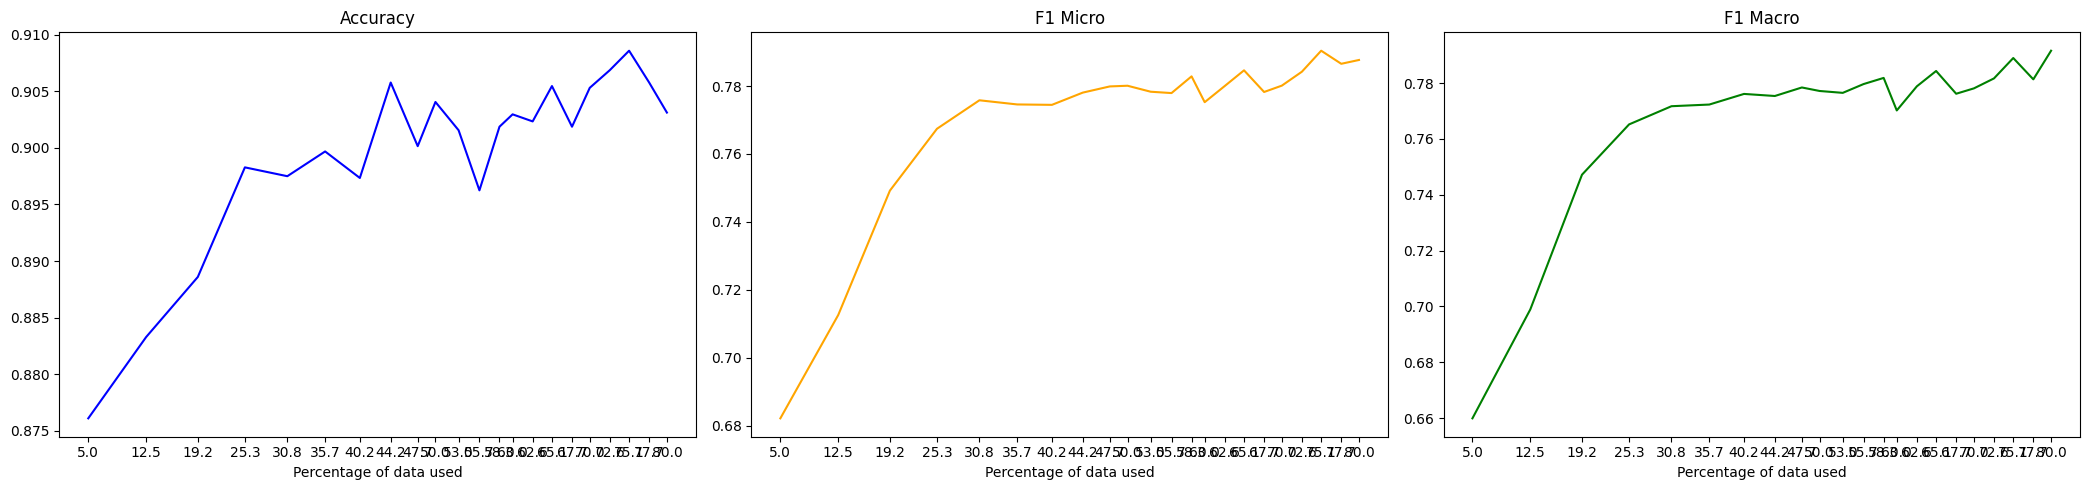

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5844, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4307, Accuracy: 0.7905, F1 Micro: 0.0346, F1 Macro: 0.0305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4004, Accuracy: 0.8223, F1 Micro: 0.2871, F1 Macro: 0.2055
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3618, Accuracy: 0.8373, F1 Micro: 0.4148, F1 Macro: 0.3304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.303, Accuracy: 0.8416, F1 Micro: 0.4416, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2804, Accuracy: 0.8517, F1 Micro: 0.5286, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2304, Accuracy: 0.8625, F1 Micro: 0.6068, F1 Macro: 0.5746
Epoch 8/10, Train Loss: 0.199, Accuracy: 0.8653, F1 Micro: 0.6009, F1 Macro: 0.5539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1798, Accuracy: 0.8691, F1 Micro: 0.64

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.511, Accuracy: 0.7955, F1 Micro: 0.0788, F1 Macro: 0.0657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4002, Accuracy: 0.83, F1 Micro: 0.3696, F1 Macro: 0.2652
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.306, Accuracy: 0.8623, F1 Micro: 0.6001, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2402, Accuracy: 0.8708, F1 Micro: 0.6342, F1 Macro: 0.614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2163, Accuracy: 0.8761, F1 Micro: 0.663, F1 Macro: 0.642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1636, Accuracy: 0.8827, F1 Micro: 0.7012, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1335, Accuracy: 0.8847, F1 Micro: 0.725, F1 Macro: 0.7194
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.8836, F1 Micro: 0.7215, F1 Macro: 0.7197
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0826, Accuracy: 0.8877, F1 Micro: 0.731

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8223, F1 Micro: 0.288, F1 Macro: 0.191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3522, Accuracy: 0.8552, F1 Micro: 0.5445, F1 Macro: 0.4706
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2751, Accuracy: 0.8694, F1 Micro: 0.6144, F1 Macro: 0.5943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2138, Accuracy: 0.8795, F1 Micro: 0.6762, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1747, Accuracy: 0.888, F1 Micro: 0.7149, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.8909, F1 Micro: 0.7441, F1 Macro: 0.7446
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.8892, F1 Micro: 0.7375, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.8939, F1 Micro: 0.7517, F1 Macro: 0.7485
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.8906, F1 Micro: 0.7244, F1 Macro: 0.7151
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.8422, F1 Micro: 0.4662, F1 Macro: 0.394
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3136, Accuracy: 0.8767, F1 Micro: 0.7181, F1 Macro: 0.7153
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.8863, F1 Micro: 0.7209, F1 Macro: 0.7117
Epoch 4/10, Train Loss: 0.2036, Accuracy: 0.8852, F1 Micro: 0.7168, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1712, Accuracy: 0.8925, F1 Micro: 0.7576, F1 Macro: 0.7472
Epoch 6/10, Train Loss: 0.1196, Accuracy: 0.8963, F1 Micro: 0.7573, F1 Macro: 0.7466
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.8864, F1 Micro: 0.7031, F1 Macro: 0.6852
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.8948, F1 Micro: 0.7555, F1 Macro: 0.7465
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.8897, F1 Micro: 0.7401, F1 Macro: 0.7343
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.8942, F1 Micro: 0.744, F1 Macro: 0.7325
Iteration 1969: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4521, Accuracy: 0.8564, F1 Micro: 0.584, F1 Macro: 0.5333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8863, F1 Micro: 0.7226, F1 Macro: 0.7117
Epoch 3/10, Train Loss: 0.2257, Accuracy: 0.8863, F1 Micro: 0.7065, F1 Macro: 0.6952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.8969, F1 Micro: 0.7572, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1466, Accuracy: 0.8948, F1 Micro: 0.7614, F1 Macro: 0.7559
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.893, F1 Micro: 0.7315, F1 Macro: 0.7201
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.8959, F1 Micro: 0.7504, F1 Macro: 0.7432
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.8958, F1 Micro: 0.7493, F1 Macro: 0.7412
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.8906, F1 Micro: 0.7498, F1 Macro: 0.7396
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.8959, F1 Micro: 0.756, F1 Macro: 0.7509
Iteration 2394: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8628, F1 Micro: 0.5965, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2766, Accuracy: 0.8836, F1 Micro: 0.6945, F1 Macro: 0.677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.8894, F1 Micro: 0.7358, F1 Macro: 0.7121
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.892, F1 Micro: 0.763, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.8966, F1 Micro: 0.7641, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.8966, F1 Micro: 0.7649, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.8972, F1 Micro: 0.763, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.8981, F1 Micro: 0.7749, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.8988, F1 Micro: 0.7544, F1 Macro: 0.748
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4292, Accuracy: 0.8669, F1 Micro: 0.6324, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.8941, F1 Micro: 0.7428, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.895, F1 Micro: 0.7703, F1 Macro: 0.7689
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.8983, F1 Micro: 0.7632, F1 Macro: 0.7616
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.8922, F1 Micro: 0.7674, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.8966, F1 Micro: 0.7719, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.8984, F1 Micro: 0.7679, F1 Macro: 0.7628
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.8972, F1 Micro: 0.7678, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.8997, F1 Micro: 0.7546, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.8986, F1 Micro: 0.7703, F1 Macro: 0.7674
Iteration 3122: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4062, Accuracy: 0.8763, F1 Micro: 0.6975, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.8894, F1 Micro: 0.7197, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.8955, F1 Micro: 0.7416, F1 Macro: 0.732
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.892, F1 Micro: 0.7117, F1 Macro: 0.6938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.8967, F1 Micro: 0.7718, F1 Macro: 0.772
Epoch 6/10, Train Loss: 0.1034, Accuracy: 0.8984, F1 Micro: 0.764, F1 Macro: 0.7623
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9, F1 Micro: 0.7663, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9023, F1 Micro: 0.7726, F1 Macro: 0.7704
Epoch 9/10, Train Loss: 0.0386, Accuracy: 0.8991, F1 Micro: 0.7614, F1 Macro: 0.7593
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9006, F1 Micro: 0.7719, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.8752, F1 Micro: 0.7154, F1 Macro: 0.7147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2613, Accuracy: 0.8927, F1 Micro: 0.7298, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.8973, F1 Micro: 0.7708, F1 Macro: 0.766
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9014, F1 Micro: 0.7678, F1 Macro: 0.7643
Epoch 5/10, Train Loss: 0.1354, Accuracy: 0.9006, F1 Micro: 0.7632, F1 Macro: 0.7579
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.9014, F1 Micro: 0.762, F1 Macro: 0.7543
Epoch 7/10, Train Loss: 0.0679, Accuracy: 0.9003, F1 Micro: 0.7685, F1 Macro: 0.7603
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.8986, F1 Micro: 0.7648, F1 Macro: 0.7594
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8969, F1 Micro: 0.7543, F1 Macro: 0.7512
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0358, Accuracy: 0.9006, F1 Micro: 0.7732, F1 Macro: 0.7717
Iteration 3711: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8772, F1 Micro: 0.7259, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2484, Accuracy: 0.8948, F1 Micro: 0.7467, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2089, Accuracy: 0.9, F1 Micro: 0.7699, F1 Macro: 0.7606
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9002, F1 Micro: 0.7624, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.8975, F1 Micro: 0.773, F1 Macro: 0.7719
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9, F1 Micro: 0.7574, F1 Macro: 0.7488
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.8991, F1 Micro: 0.7614, F1 Macro: 0.7529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9, F1 Micro: 0.7737, F1 Macro: 0.7705
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9011, F1 Micro: 0.7679, F1 Macro: 0.7661
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.8969, F1 Micro: 0.7658, F1 Macro: 0.76

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4004, Accuracy: 0.8792, F1 Micro: 0.7026, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.8961, F1 Micro: 0.7542, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9003, F1 Micro: 0.7626, F1 Macro: 0.7504
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.8984, F1 Micro: 0.7459, F1 Macro: 0.7322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7695
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9017, F1 Micro: 0.7607, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0677, Accuracy: 0.8998, F1 Micro: 0.7755, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.8995, F1 Micro: 0.7673, F1 Macro: 0.7616
Epoch 9/10, Train Loss: 0.0394, Accuracy: 0.8998, F1 Micro: 0.7673, F1 Macro: 0.7635
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.8963, F1 Micro: 0.7704, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3865, Accuracy: 0.8814, F1 Micro: 0.6941, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.8955, F1 Micro: 0.743, F1 Macro: 0.7344
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.8991, F1 Micro: 0.737, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9013, F1 Micro: 0.762, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.8975, F1 Micro: 0.7719, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9002, F1 Micro: 0.7696, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9019, F1 Micro: 0.7681, F1 Macro: 0.7623
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.8997, F1 Micro: 0.7701, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9022, F1 Micro: 0.7681, F1 Macro: 0.7595
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9027, F1 Micro: 0.7739, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8822, F1 Micro: 0.6962, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.8961, F1 Micro: 0.7453, F1 Macro: 0.7277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.8973, F1 Micro: 0.7678, F1 Macro: 0.7652
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.8956, F1 Micro: 0.7533, F1 Macro: 0.7481
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9016, F1 Micro: 0.7626, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.8972, F1 Micro: 0.7718, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.8983, F1 Micro: 0.7568, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0507, Accuracy: 0.9022, F1 Micro: 0.7722, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.8989, F1 Micro: 0.7805, F1 Macro: 0.7794
Epoch 10/10, Train Loss: 0.0346, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8822, F1 Micro: 0.6996, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.8967, F1 Micro: 0.7627, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.196, Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macro: 0.7663
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9005, F1 Micro: 0.7719, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.8997, F1 Micro: 0.7525, F1 Macro: 0.7462
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9042, F1 Micro: 0.7654, F1 Macro: 0.7575
Epoch 7/10, Train Loss: 0.0664, Accuracy: 0.8944, F1 Micro: 0.7736, F1 Macro: 0.7741
Epoch 8/10, Train Loss: 0.054, Accuracy: 0.898, F1 Micro: 0.7721, F1 Macro: 0.7693
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.8977, F1 Micro: 0.7617, F1 Macro: 0.7567
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9, F1 Micro: 0.761, F1 Macro: 0.7553
Iteration 4663: Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8816, F1 Micro: 0.6926, F1 Macro: 0.6688
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.8966, F1 Micro: 0.7519, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.8998, F1 Micro: 0.7586, F1 Macro: 0.7535
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1603, Accuracy: 0.9027, F1 Micro: 0.772, F1 Macro: 0.7716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.8978, F1 Micro: 0.7735, F1 Macro: 0.7708
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9016, F1 Micro: 0.7674, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9052, F1 Micro: 0.7722, F1 Macro: 0.7651
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9002, F1 Micro: 0.7697, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9017, F1 Micro: 0.7714, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0343, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3793, Accuracy: 0.8856, F1 Micro: 0.7323, F1 Macro: 0.7293
Epoch 2/10, Train Loss: 0.237, Accuracy: 0.8936, F1 Micro: 0.724, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9055, F1 Micro: 0.7807, F1 Macro: 0.7756
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1565, Accuracy: 0.9014, F1 Micro: 0.7847, F1 Macro: 0.786
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9023, F1 Micro: 0.7822, F1 Macro: 0.7765
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9044, F1 Micro: 0.7833, F1 Macro: 0.7818
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9067, F1 Micro: 0.7875, F1 Macro: 0.7864
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9048, F1 Micro: 0.7735, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.902, F1 Micro: 0.7796, F1 Macro: 0.7749
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.902, F1 Micro: 0.779, F1 Macro: 0.7727
Iteration 5063: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3645, Accuracy: 0.8889, F1 Micro: 0.7373, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.8986, F1 Micro: 0.7478, F1 Macro: 0.7424
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9038, F1 Micro: 0.7623, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9098, F1 Micro: 0.7941, F1 Macro: 0.7924
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9016, F1 Micro: 0.7786, F1 Macro: 0.7769
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.9052, F1 Micro: 0.7798, F1 Macro: 0.7721
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9042, F1 Micro: 0.7832, F1 Macro: 0.7826
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9058, F1 Micro: 0.7779, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9031, F1 Micro: 0.7655, F1 Macro: 0.756
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9039, F1 Micro: 0.7818, F1 Macro: 0.7821
Iteration 5263: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3772, Accuracy: 0.8886, F1 Micro: 0.7244, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.897, F1 Micro: 0.7598, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1934, Accuracy: 0.8944, F1 Micro: 0.7702, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9028, F1 Micro: 0.7708, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9041, F1 Micro: 0.7746, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9014, F1 Micro: 0.781, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9014, F1 Micro: 0.7784, F1 Macro: 0.7759
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9009, F1 Micro: 0.7721, F1 Macro: 0.7693
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.903, F1 Micro: 0.7835, F1 Macro: 0.7845
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3676, Accuracy: 0.8834, F1 Micro: 0.7442, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2404, Accuracy: 0.8995, F1 Micro: 0.7698, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.9042, F1 Micro: 0.7859, F1 Macro: 0.7791
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9042, F1 Micro: 0.771, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9017, F1 Micro: 0.7832, F1 Macro: 0.7782
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9022, F1 Micro: 0.762, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9019, F1 Micro: 0.7738, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.897, F1 Micro: 0.7768, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9031, F1 Micro: 0.7657, F1 Macro: 0.7581
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9022, F1 Micro: 0.773, F1 Macro: 0.7641
Iteration 5641: Accuracy: 0.9042, F1 Micro: 0.7859, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3671, Accuracy: 0.8805, F1 Micro: 0.7509, F1 Macro: 0.7555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9009, F1 Micro: 0.7593, F1 Macro: 0.7399
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9041, F1 Micro: 0.7729, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9022, F1 Micro: 0.7832, F1 Macro: 0.7822
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9019, F1 Micro: 0.7665, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9006, F1 Micro: 0.7623, F1 Macro: 0.7569
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9031, F1 Micro: 0.7763, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.905, F1 Micro: 0.7728, F1 Macro: 0.7706
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9031, F1 Micro: 0.7812, F1 Macro: 0.7802
Epoch 10/10, Train Loss: 0.0296, Accuracy: 0.9036, F1 Micro: 0.7791, F1 Macro: 0.7775
Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8892, F1 Micro: 0.7342, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9002, F1 Micro: 0.7471, F1 Macro: 0.7356
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.9092, F1 Micro: 0.7855, F1 Macro: 0.781
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9038, F1 Micro: 0.7691, F1 Macro: 0.7598
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9053, F1 Micro: 0.7765, F1 Macro: 0.7668
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9039, F1 Micro: 0.7654, F1 Macro: 0.7553
Epoch 7/10, Train Loss: 0.0651, Accuracy: 0.9055, F1 Micro: 0.7758, F1 Macro: 0.7676
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9055, F1 Micro: 0.7794, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.8988, F1 Micro: 0.7747, F1 Macro: 0.7741
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9052, F1 Micro: 0.7707, F1 Macro: 0.762
Iteration 6041: Accuracy: 0.9092, F1 Micro: 0.7855, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3566, Accuracy: 0.8956, F1 Micro: 0.7511, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9027, F1 Micro: 0.7769, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.91, F1 Micro: 0.7805, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1544, Accuracy: 0.9064, F1 Micro: 0.781, F1 Macro: 0.7742
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9092, F1 Micro: 0.7783, F1 Macro: 0.7709
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9042, F1 Micro: 0.7793, F1 Macro: 0.775
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9005, F1 Micro: 0.7759, F1 Macro: 0.7733
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.903, F1 Micro: 0.7769, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9073, F1 Micro: 0.78, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0307, Accuracy: 0.9027, F1 Micro: 0.7757, F1 Macro: 0.771
Iteration 6218: Accuracy:

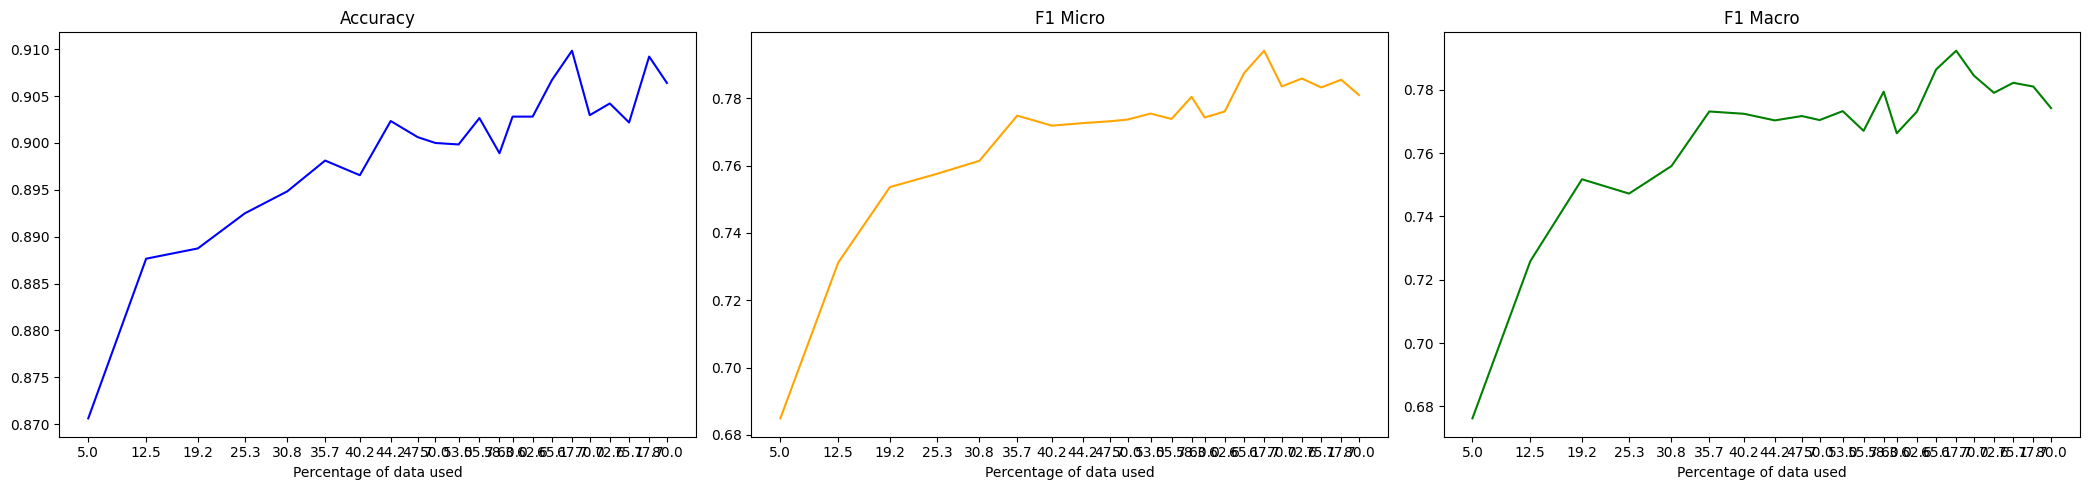

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6208, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4476, Accuracy: 0.7894, F1 Micro: 0.0246, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4214, Accuracy: 0.8112, F1 Micro: 0.2063, F1 Macro: 0.149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3908, Accuracy: 0.827, F1 Micro: 0.3407, F1 Macro: 0.2543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3554, Accuracy: 0.8383, F1 Micro: 0.4408, F1 Macro: 0.3616
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2953, Accuracy: 0.8547, F1 Micro: 0.5432, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2514, Accuracy: 0.8706, F1 Micro: 0.6607, F1 Macro: 0.6457
Epoch 8/10, Train Loss: 0.216, Accuracy: 0.8611, F1 Micro: 0.5946, F1 Macro: 0.5687
Epoch 9/10, Train Loss: 0.1615, Accuracy: 0.8661, F1 Micro: 0.6352, F1 Macro: 0.6212
Higher F1 achi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5445, Accuracy: 0.7967, F1 Micro: 0.0896, F1 Macro: 0.0737
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3931, Accuracy: 0.8323, F1 Micro: 0.3989, F1 Macro: 0.2935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.31, Accuracy: 0.8781, F1 Micro: 0.6882, F1 Macro: 0.6767
Epoch 4/10, Train Loss: 0.2508, Accuracy: 0.8767, F1 Micro: 0.6757, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2017, Accuracy: 0.885, F1 Micro: 0.7079, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1676, Accuracy: 0.8867, F1 Micro: 0.7147, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1252, Accuracy: 0.8841, F1 Micro: 0.7296, F1 Macro: 0.7245
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.8877, F1 Micro: 0.7265, F1 Macro: 0.7219
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.8869, F1 Micro: 0.7311, F1 Macro: 0.7261
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5159, Accuracy: 0.8213, F1 Micro: 0.2814, F1 Macro: 0.1915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3595, Accuracy: 0.8728, F1 Micro: 0.6568, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.254, Accuracy: 0.8856, F1 Micro: 0.7263, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.8881, F1 Micro: 0.7396, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.8847, F1 Micro: 0.7436, F1 Macro: 0.7419
Epoch 6/10, Train Loss: 0.1204, Accuracy: 0.8889, F1 Micro: 0.7385, F1 Macro: 0.7353
Epoch 7/10, Train Loss: 0.0934, Accuracy: 0.8856, F1 Micro: 0.7365, F1 Macro: 0.7386
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.8898, F1 Micro: 0.7382, F1 Macro: 0.7321
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.8856, F1 Micro: 0.7189, F1 Macro: 0.7127
Epoch 10/10, Train Loss: 0.0557, Accuracy: 0.8869, F1 Micro: 0.7416, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8414, F1 Micro: 0.4787, F1 Macro: 0.3971
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3111, Accuracy: 0.8786, F1 Micro: 0.7147, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2343, Accuracy: 0.8894, F1 Micro: 0.7407, F1 Macro: 0.7374
Epoch 4/10, Train Loss: 0.1989, Accuracy: 0.89, F1 Micro: 0.722, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.8941, F1 Micro: 0.7447, F1 Macro: 0.742
Epoch 6/10, Train Loss: 0.1194, Accuracy: 0.8925, F1 Micro: 0.735, F1 Macro: 0.7233
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.8913, F1 Micro: 0.7447, F1 Macro: 0.7368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.8906, F1 Micro: 0.7467, F1 Macro: 0.7449
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.8931, F1 Micro: 0.7457, F1 Macro: 0.7416
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0466, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4621, Accuracy: 0.8431, F1 Micro: 0.4665, F1 Macro: 0.395
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.8836, F1 Micro: 0.72, F1 Macro: 0.7189
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.233, Accuracy: 0.8944, F1 Micro: 0.7368, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1869, Accuracy: 0.8963, F1 Micro: 0.7456, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1527, Accuracy: 0.895, F1 Micro: 0.7515, F1 Macro: 0.7465
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.8927, F1 Micro: 0.7257, F1 Macro: 0.7152
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8942, F1 Micro: 0.7463, F1 Macro: 0.7395
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.8927, F1 Micro: 0.7483, F1 Macro: 0.7429
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.8945, F1 Micro: 0.7469, F1 Macro: 0.7444
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0416, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.8595, F1 Micro: 0.5753, F1 Macro: 0.4962
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2802, Accuracy: 0.8852, F1 Micro: 0.7244, F1 Macro: 0.713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.8934, F1 Micro: 0.7538, F1 Macro: 0.7519
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.8959, F1 Micro: 0.7524, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.8964, F1 Micro: 0.7549, F1 Macro: 0.7526
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.8886, F1 Micro: 0.7492, F1 Macro: 0.7467
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.8933, F1 Micro: 0.7532, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.8953, F1 Micro: 0.7574, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.8952, F1 Micro: 0.7591, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0393, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4355, Accuracy: 0.8664, F1 Micro: 0.6503, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.89, F1 Micro: 0.7412, F1 Macro: 0.7395
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2204, Accuracy: 0.8945, F1 Micro: 0.7576, F1 Macro: 0.7527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.188, Accuracy: 0.8928, F1 Micro: 0.7628, F1 Macro: 0.7623
Epoch 5/10, Train Loss: 0.1531, Accuracy: 0.8945, F1 Micro: 0.755, F1 Macro: 0.7481
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.8959, F1 Micro: 0.7413, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.897, F1 Micro: 0.7656, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.8967, F1 Micro: 0.7615, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.8872, F1 Micro: 0.7641, F1 Macro: 0.7689
Epoch 10/10, Train Loss: 0.0375, Accuracy: 0.8948, F1 Micro: 0.7614, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8731, F1 Micro: 0.6585, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.892, F1 Micro: 0.747, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2134, Accuracy: 0.8973, F1 Micro: 0.7524, F1 Macro: 0.7469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.8969, F1 Micro: 0.7537, F1 Macro: 0.7471
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.8916, F1 Micro: 0.7409, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.8963, F1 Micro: 0.7647, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.8977, F1 Micro: 0.767, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.8944, F1 Micro: 0.7587, F1 Macro: 0.7533
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.8948, F1 Micro: 0.7631, F1 Macro: 0.7589
Epoch 10/10, Train Loss: 0.0374, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4094, Accuracy: 0.8737, F1 Micro: 0.6619, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.8972, F1 Micro: 0.7593, F1 Macro: 0.7516
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2039, Accuracy: 0.897, F1 Micro: 0.763, F1 Macro: 0.7536
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.8984, F1 Micro: 0.7587, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1432, Accuracy: 0.8928, F1 Micro: 0.7715, F1 Macro: 0.7727
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9008, F1 Micro: 0.7601, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.8963, F1 Micro: 0.7622, F1 Macro: 0.7591
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.8989, F1 Micro: 0.7615, F1 Macro: 0.7571
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.8978, F1 Micro: 0.7615, F1 Macro: 0.7564
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9009, F1 Micro: 0.7674, F1 Macro: 0.7605
Iteration 3711: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8742, F1 Micro: 0.6449, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.8945, F1 Micro: 0.7604, F1 Macro: 0.7598
Epoch 3/10, Train Loss: 0.2088, Accuracy: 0.8994, F1 Micro: 0.7573, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1642, Accuracy: 0.8944, F1 Micro: 0.7653, F1 Macro: 0.7621
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.8969, F1 Micro: 0.7636, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.8991, F1 Micro: 0.7685, F1 Macro: 0.7646
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.8997, F1 Micro: 0.7689, F1 Macro: 0.7656
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.8972, F1 Micro: 0.7625, F1 Macro: 0.7592
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8933, F1 Micro: 0.7611, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.8973, F1 Micro: 0.7615, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4014, Accuracy: 0.8758, F1 Micro: 0.6714, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2544, Accuracy: 0.8925, F1 Micro: 0.7427, F1 Macro: 0.7435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2179, Accuracy: 0.8944, F1 Micro: 0.7621, F1 Macro: 0.7618
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.898, F1 Micro: 0.7591, F1 Macro: 0.7521
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.8984, F1 Micro: 0.7515, F1 Macro: 0.7408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.897, F1 Micro: 0.7693, F1 Macro: 0.7674
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.895, F1 Micro: 0.7605, F1 Macro: 0.7575
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9006, F1 Micro: 0.7614, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8955, F1 Micro: 0.7665, F1 Macro: 0.765
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.8961, F1 Micro: 0.7463, F1 Macro: 0.741
Iteration 4120: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8806, F1 Micro: 0.7043, F1 Macro: 0.7057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.8952, F1 Micro: 0.733, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.8986, F1 Micro: 0.7448, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.9008, F1 Micro: 0.7532, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1291, Accuracy: 0.9011, F1 Micro: 0.7557, F1 Macro: 0.7415
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9003, F1 Micro: 0.7675, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8984, F1 Micro: 0.7734, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.0539, Accuracy: 0.898, F1 Micro: 0.7612, F1 Macro: 0.7563
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.8989, F1 Micro: 0.7629, F1 Macro: 0.7599
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8741, F1 Micro: 0.6523, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2456, Accuracy: 0.8936, F1 Micro: 0.7486, F1 Macro: 0.7481
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.8967, F1 Micro: 0.7376, F1 Macro: 0.7256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9008, F1 Micro: 0.7713, F1 Macro: 0.7686
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.8994, F1 Micro: 0.7527, F1 Macro: 0.7467
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.8975, F1 Micro: 0.7569, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.8889, F1 Micro: 0.7578, F1 Macro: 0.7591
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.9013, F1 Micro: 0.7658, F1 Macro: 0.7599
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9019, F1 Micro: 0.7648, F1 Macro: 0.7556
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9036, F1 Micro: 0.7658, F1 Macro: 0.7637
Iteration 4530: Accuracy: 0.9008, F1 Micro: 0.7713, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8786, F1 Micro: 0.724, F1 Macro: 0.7239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.8969, F1 Micro: 0.7537, F1 Macro: 0.7406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.8977, F1 Micro: 0.7712, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.903, F1 Micro: 0.7756, F1 Macro: 0.7753
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.8991, F1 Micro: 0.7635, F1 Macro: 0.7575
Epoch 6/10, Train Loss: 0.0976, Accuracy: 0.8948, F1 Micro: 0.7523, F1 Macro: 0.7456
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9031, F1 Micro: 0.7697, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.8936, F1 Micro: 0.7613, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9008, F1 Micro: 0.7677, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.8997, F1 Micro: 0.7722, F1 Macro: 0.7709
Iteration 4663: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3931, Accuracy: 0.882, F1 Micro: 0.7182, F1 Macro: 0.7193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.8944, F1 Micro: 0.7682, F1 Macro: 0.7667
Epoch 3/10, Train Loss: 0.2018, Accuracy: 0.9027, F1 Micro: 0.7661, F1 Macro: 0.761
Epoch 4/10, Train Loss: 0.1606, Accuracy: 0.9009, F1 Micro: 0.7679, F1 Macro: 0.7627
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9013, F1 Micro: 0.7466, F1 Macro: 0.7319
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9011, F1 Micro: 0.7596, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.8959, F1 Micro: 0.7684, F1 Macro: 0.7702
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9003, F1 Micro: 0.7677, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.8998, F1 Micro: 0.7688, F1 Macro: 0.767
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.8995, F1 Micro: 0.7726, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.388, Accuracy: 0.8841, F1 Micro: 0.7083, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2412, Accuracy: 0.8969, F1 Micro: 0.771, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9005, F1 Micro: 0.7759, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7724
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.8981, F1 Micro: 0.7741, F1 Macro: 0.7721
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9034, F1 Micro: 0.7678, F1 Macro: 0.7607
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.8958, F1 Micro: 0.7699, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9008, F1 Micro: 0.7713, F1 Macro: 0.771
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9016, F1 Micro: 0.7729, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.8981, F1 Micro: 0.7694, F1 Macro: 0.7664
Iteration 5063: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8872, F1 Micro: 0.7346, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9008, F1 Micro: 0.7626, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.895, F1 Micro: 0.7754, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9039, F1 Micro: 0.7764, F1 Macro: 0.7683
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.8981, F1 Micro: 0.7658, F1 Macro: 0.7605
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.8986, F1 Micro: 0.7706, F1 Macro: 0.7669
Epoch 7/10, Train Loss: 0.0713, Accuracy: 0.9011, F1 Micro: 0.7686, F1 Macro: 0.764
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8983, F1 Micro: 0.7717, F1 Macro: 0.7751
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.9, F1 Micro: 0.7666, F1 Macro: 0.7609
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.8973, F1 Micro: 0.7704, F1 Macro: 0.7686
Iteration 5263: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8894, F1 Micro: 0.7382, F1 Macro: 0.7296
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8972, F1 Micro: 0.7338, F1 Macro: 0.7253
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9042, F1 Micro: 0.7606, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9028, F1 Micro: 0.7771, F1 Macro: 0.7718
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9016, F1 Micro: 0.7734, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9025, F1 Micro: 0.7711, F1 Macro: 0.7656
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.8964, F1 Micro: 0.7673, F1 Macro: 0.7647
Epoch 8/10, Train Loss: 0.0474, Accuracy: 0.8988, F1 Micro: 0.7633, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9003, F1 Micro: 0.769, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.9011, F1 Micro: 0.7722, F1 Macro: 0.7717
Iteration 5441: Accuracy: 0.9028, F1 Micro: 0.7771, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3789, Accuracy: 0.89, F1 Micro: 0.729, F1 Macro: 0.7261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2416, Accuracy: 0.8956, F1 Micro: 0.7674, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2042, Accuracy: 0.9036, F1 Micro: 0.7752, F1 Macro: 0.7735
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9011, F1 Micro: 0.7775, F1 Macro: 0.7769
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.897, F1 Micro: 0.7703, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.9034, F1 Micro: 0.772, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0638, Accuracy: 0.9027, F1 Micro: 0.7782, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9072, F1 Micro: 0.7823, F1 Macro: 0.7825
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.8992, F1 Micro: 0.7565, F1 Macro: 0.7481
Epoch 10/10, Train Loss: 0.03, Accuracy: 0.900

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8866, F1 Micro: 0.7068, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2382, Accuracy: 0.9036, F1 Micro: 0.7729, F1 Macro: 0.7636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.9055, F1 Micro: 0.7765, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9062, F1 Micro: 0.7826, F1 Macro: 0.781
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.8978, F1 Micro: 0.7807, F1 Macro: 0.7828
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.8995, F1 Micro: 0.7777, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.8961, F1 Micro: 0.7753, F1 Macro: 0.7784
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.9031, F1 Micro: 0.763, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9033, F1 Micro: 0.7745, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9031, F1 Micro: 0.765, F1 Macro: 0.7591
Iteration 5841: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3751, Accuracy: 0.8883, F1 Micro: 0.7303, F1 Macro: 0.7222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.8989, F1 Micro: 0.7687, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9034, F1 Micro: 0.7767, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9056, F1 Micro: 0.7824, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9014, F1 Micro: 0.781, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9047, F1 Micro: 0.7746, F1 Macro: 0.7704
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.9036, F1 Micro: 0.7721, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9045, F1 Micro: 0.7736, F1 Macro: 0.7691
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9019, F1 Micro: 0.7749, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0342, Accuracy: 0.9027, F1 Micro: 0.7729, F1 Macro: 0.7692
Iteration 6041: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3647, Accuracy: 0.8905, F1 Micro: 0.7374, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.902, F1 Micro: 0.781, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1909, Accuracy: 0.9089, F1 Micro: 0.7884, F1 Macro: 0.7816
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.9056, F1 Micro: 0.7878, F1 Macro: 0.7881
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9052, F1 Micro: 0.7771, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9048, F1 Micro: 0.7837, F1 Macro: 0.7813
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9025, F1 Micro: 0.7741, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.902, F1 Micro: 0.7739, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9048, F1 Micro: 0.7754, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9064, F1 Micro: 0.7843, F1 Macro: 0.7856
Iteration 6218: Accuracy: 0.9089, F1 Micro: 0.7884, F1 Ma

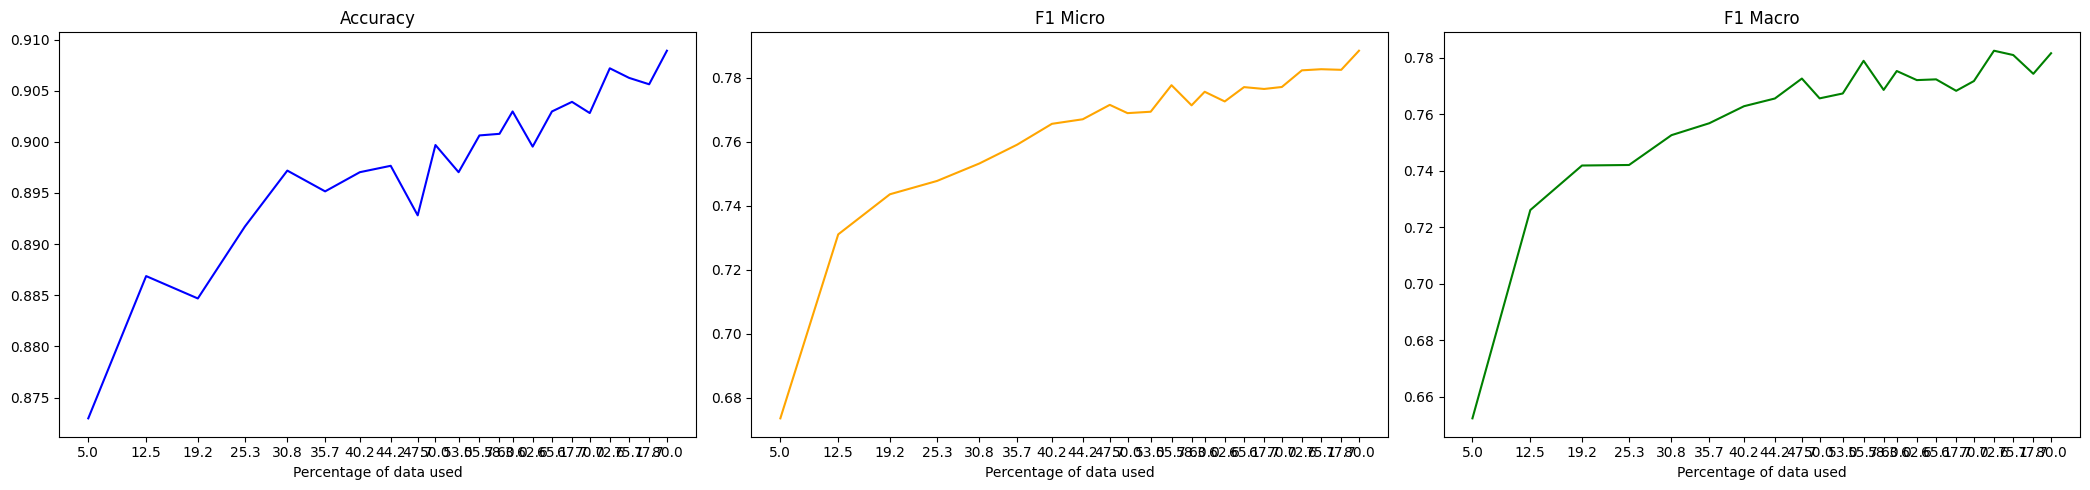

In [22]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.597, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4984, Accuracy: 0.7869, F1 Micro: 0.0015, F1 Macro: 0.0013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.434, Accuracy: 0.8289, F1 Micro: 0.3455, F1 Macro: 0.233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4, Accuracy: 0.833, F1 Micro: 0.4206, F1 Macro: 0.3057
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3437, Accuracy: 0.8411, F1 Micro: 0.4639, F1 Macro: 0.3624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2958, Accuracy: 0.8586, F1 Micro: 0.6046, F1 Macro: 0.5339
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2619, Accuracy: 0.8728, F1 Micro: 0.6625, F1 Macro: 0.6387
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2157, Accuracy: 0.8705, F1 Micro: 0.6691, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1979, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.545, Accuracy: 0.8011, F1 Micro: 0.1263, F1 Macro: 0.0996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4046, Accuracy: 0.8514, F1 Micro: 0.5628, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3259, Accuracy: 0.8764, F1 Micro: 0.6945, F1 Macro: 0.6801
Epoch 4/10, Train Loss: 0.2531, Accuracy: 0.8792, F1 Micro: 0.6862, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2075, Accuracy: 0.8814, F1 Micro: 0.7013, F1 Macro: 0.6954
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1615, Accuracy: 0.8834, F1 Micro: 0.7193, F1 Macro: 0.7096
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.8839, F1 Micro: 0.7167, F1 Macro: 0.7022
Epoch 8/10, Train Loss: 0.1031, Accuracy: 0.8839, F1 Micro: 0.7087, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0846, Accuracy: 0.8842, F1 Micro: 0.7198, F1 Macro: 0.7062
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4968, Accuracy: 0.8328, F1 Micro: 0.3829, F1 Macro: 0.2668
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3585, Accuracy: 0.8689, F1 Micro: 0.6794, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2828, Accuracy: 0.8828, F1 Micro: 0.7113, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2263, Accuracy: 0.8886, F1 Micro: 0.7404, F1 Macro: 0.7318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1759, Accuracy: 0.8908, F1 Micro: 0.747, F1 Macro: 0.7428
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.8889, F1 Micro: 0.7453, F1 Macro: 0.7416
Epoch 7/10, Train Loss: 0.1051, Accuracy: 0.8844, F1 Micro: 0.738, F1 Macro: 0.7349
Epoch 8/10, Train Loss: 0.0857, Accuracy: 0.8917, F1 Micro: 0.7313, F1 Macro: 0.7213
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.8869, F1 Micro: 0.7434, F1 Macro: 0.7395
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.8861, F1 Micro: 0.7293, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8305, F1 Micro: 0.3666, F1 Macro: 0.2704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.318, Accuracy: 0.8741, F1 Micro: 0.6486, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2496, Accuracy: 0.8911, F1 Micro: 0.7416, F1 Macro: 0.7338
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.8923, F1 Micro: 0.7397, F1 Macro: 0.7244
Epoch 5/10, Train Loss: 0.1671, Accuracy: 0.8931, F1 Micro: 0.7349, F1 Macro: 0.726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.8897, F1 Micro: 0.7533, F1 Macro: 0.7512
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8917, F1 Micro: 0.7442, F1 Macro: 0.7366
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.8939, F1 Micro: 0.7512, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.8909, F1 Micro: 0.7504, F1 Macro: 0.7505
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.8928, F1 Micro: 0.7478, F1 Macro: 0.7458
Iteration 1969: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4425, Accuracy: 0.8478, F1 Micro: 0.4922, F1 Macro: 0.4207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2903, Accuracy: 0.8869, F1 Micro: 0.7268, F1 Macro: 0.7268
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.8897, F1 Micro: 0.7075, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.8791, F1 Micro: 0.7502, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.8919, F1 Micro: 0.7359, F1 Macro: 0.7276
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.8934, F1 Micro: 0.7457, F1 Macro: 0.7383
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.8903, F1 Micro: 0.7484, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.8917, F1 Micro: 0.7524, F1 Macro: 0.7492
Epoch 9/10, Train Loss: 0.0448, Accuracy: 0.8922, F1 Micro: 0.7398, F1 Macro: 0.7342
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.8925, F1 Micro: 0.7471, F1 Macro: 0.7444
Iteration 2394: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4341, Accuracy: 0.8605, F1 Micro: 0.5746, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.8919, F1 Micro: 0.7416, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.8978, F1 Micro: 0.7459, F1 Macro: 0.7336
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.8942, F1 Micro: 0.7357, F1 Macro: 0.7246
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1514, Accuracy: 0.8977, F1 Micro: 0.7562, F1 Macro: 0.7509
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.8959, F1 Micro: 0.7462, F1 Macro: 0.7388
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.8938, F1 Micro: 0.7632, F1 Macro: 0.7619
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.8966, F1 Micro: 0.7418, F1 Macro: 0.7366
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8941, F1 Micro: 0.7556, F1 Macro: 0.7509
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.8964, F1 Micro: 0.7495, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4241, Accuracy: 0.8534, F1 Micro: 0.5442, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.276, Accuracy: 0.8911, F1 Micro: 0.7304, F1 Macro: 0.7224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.8986, F1 Micro: 0.7474, F1 Macro: 0.7342
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1788, Accuracy: 0.8984, F1 Micro: 0.7558, F1 Macro: 0.7513
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.8977, F1 Micro: 0.742, F1 Macro: 0.7313
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.8984, F1 Micro: 0.7682, F1 Macro: 0.7668
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.8952, F1 Micro: 0.7628, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0586, Accuracy: 0.8981, F1 Micro: 0.754, F1 Macro: 0.7518
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.8973, F1 Micro: 0.7501, F1 Macro: 0.7453
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.8969, F1 Micro: 0.7454, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8664, F1 Micro: 0.6284, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.8942, F1 Micro: 0.7423, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9003, F1 Micro: 0.7488, F1 Macro: 0.74
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.8997, F1 Micro: 0.7586, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.8983, F1 Micro: 0.7669, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.8981, F1 Micro: 0.7543, F1 Macro: 0.7475
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8939, F1 Micro: 0.7613, F1 Macro: 0.7603
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.8986, F1 Micro: 0.7639, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.8984, F1 Micro: 0.7665, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.8967, F1 Micro: 0.752, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4089, Accuracy: 0.877, F1 Micro: 0.6773, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2655, Accuracy: 0.893, F1 Micro: 0.7426, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2113, Accuracy: 0.8991, F1 Micro: 0.7564, F1 Macro: 0.7468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.8994, F1 Micro: 0.7622, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1329, Accuracy: 0.8977, F1 Micro: 0.7712, F1 Macro: 0.7684
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9038, F1 Micro: 0.7594, F1 Macro: 0.7503
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9011, F1 Micro: 0.7653, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.8998, F1 Micro: 0.7739, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0416, Accuracy: 0.9, F1 Micro: 0.7603, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0334, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3992, Accuracy: 0.8712, F1 Micro: 0.636, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.8922, F1 Micro: 0.7374, F1 Macro: 0.7218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.8958, F1 Micro: 0.7701, F1 Macro: 0.7693
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9027, F1 Micro: 0.7495, F1 Macro: 0.7366
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.8994, F1 Micro: 0.7568, F1 Macro: 0.7468
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9011, F1 Micro: 0.7637, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8919, F1 Micro: 0.7678, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.8944, F1 Micro: 0.7491, F1 Macro: 0.7416
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9005, F1 Micro: 0.7635, F1 Macro: 0.7594
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9006, F1 Micro: 0.7663, F1 Macro: 0.7627
Iteration 3886: Accuracy: 0.8958, F1 Micro: 0.7701, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8823, F1 Micro: 0.7245, F1 Macro: 0.7209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8961, F1 Micro: 0.7453, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2063, Accuracy: 0.8988, F1 Micro: 0.7551, F1 Macro: 0.7494
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.8995, F1 Micro: 0.7477, F1 Macro: 0.7389
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.8994, F1 Micro: 0.7608, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.8981, F1 Micro: 0.7761, F1 Macro: 0.7771
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.8998, F1 Micro: 0.7655, F1 Macro: 0.7586
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.8997, F1 Micro: 0.7612, F1 Macro: 0.7559
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.8998, F1 Micro: 0.767, F1 Macro: 0.7588
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.8956, F1 Micro: 0.7595, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8789, F1 Micro: 0.7009, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2522, Accuracy: 0.8966, F1 Micro: 0.7591, F1 Macro: 0.7599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9013, F1 Micro: 0.7656, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9009, F1 Micro: 0.7734, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.8942, F1 Micro: 0.7652, F1 Macro: 0.7627
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9031, F1 Micro: 0.7621, F1 Macro: 0.7541
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8914, F1 Micro: 0.7675, F1 Macro: 0.7688
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9003, F1 Micro: 0.7668, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0436, Accuracy: 0.8981, F1 Micro: 0.7719, F1 Macro: 0.7711
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.8981, F1 Micro: 0.7663, F1 Macro: 0.766
Iteration 4330: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8786, F1 Micro: 0.6925, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.8972, F1 Micro: 0.7452, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9, F1 Micro: 0.7762, F1 Macro: 0.7748
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.8998, F1 Micro: 0.7705, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.898, F1 Micro: 0.7771, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.8956, F1 Micro: 0.764, F1 Macro: 0.7601
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9027, F1 Micro: 0.7655, F1 Macro: 0.7581
Epoch 8/10, Train Loss: 0.0496, Accuracy: 0.9005, F1 Micro: 0.7662, F1 Macro: 0.762
Epoch 9/10, Train Loss: 0.0396, Accuracy: 0.9, F1 Micro: 0.7701, F1 Macro: 0.7659
Epoch 10/10, Train Loss: 0.0332, Accuracy: 0.8972, F1 Micro: 0.7675, F1 Macro: 0.7677
Iteration 4530: Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8839, F1 Micro: 0.7191, F1 Macro: 0.7141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.8883, F1 Micro: 0.7652, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9045, F1 Micro: 0.7753, F1 Macro: 0.7683
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.8997, F1 Micro: 0.7735, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9045, F1 Micro: 0.7771, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9039, F1 Micro: 0.7709, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9052, F1 Micro: 0.7664, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.9038, F1 Micro: 0.7696, F1 Macro: 0.7612
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0359, Accuracy: 0.9023, F1 Micro: 0.7772, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.903, F1 Micro: 0.7679, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.382, Accuracy: 0.8792, F1 Micro: 0.6799, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.8966, F1 Micro: 0.7622, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9013, F1 Micro: 0.772, F1 Macro: 0.7681
Epoch 4/10, Train Loss: 0.1632, Accuracy: 0.8997, F1 Micro: 0.7654, F1 Macro: 0.7594
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9013, F1 Micro: 0.7638, F1 Macro: 0.7537
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.902, F1 Micro: 0.7714, F1 Macro: 0.7694
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9017, F1 Micro: 0.7638, F1 Macro: 0.7535
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9003, F1 Micro: 0.7687, F1 Macro: 0.7654
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9016, F1 Micro: 0.7692, F1 Macro: 0.7649
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9002, F1 Micro: 0.7662, F1 Macro: 0.7596
Iteration 4863: Accuracy: 0.9013, F1 Micro: 0.772, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3776, Accuracy: 0.8823, F1 Micro: 0.7008, F1 Macro: 0.7004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.898, F1 Micro: 0.7582, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9039, F1 Micro: 0.7758, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.903, F1 Micro: 0.777, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1147, Accuracy: 0.9027, F1 Micro: 0.7715, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.0927, Accuracy: 0.9053, F1 Micro: 0.7765, F1 Macro: 0.769
Epoch 7/10, Train Loss: 0.067, Accuracy: 0.903, F1 Micro: 0.7729, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.05, Accuracy: 0.9005, F1 Micro: 0.7671, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0375, Accuracy: 0.9027, F1 Micro: 0.7774, F1 Macro: 0.7748
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9055, F1 Micro: 0.776, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3716, Accuracy: 0.8856, F1 Micro: 0.7464, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.9016, F1 Micro: 0.7606, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9, F1 Micro: 0.7841, F1 Macro: 0.782
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9022, F1 Micro: 0.7802, F1 Macro: 0.7784
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9048, F1 Micro: 0.7728, F1 Macro: 0.7642
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9033, F1 Micro: 0.7769, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9044, F1 Micro: 0.7689, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9039, F1 Micro: 0.773, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9045, F1 Micro: 0.7735, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.9047, F1 Micro: 0.7835, F1 Macro: 0.7818
Iteration 5263: Accuracy: 0.9, F1 Micro: 0.7841, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8788, F1 Micro: 0.6777, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.8997, F1 Micro: 0.7626, F1 Macro: 0.752
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.8991, F1 Micro: 0.7389, F1 Macro: 0.7184
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9038, F1 Micro: 0.7851, F1 Macro: 0.7839
Epoch 5/10, Train Loss: 0.126, Accuracy: 0.903, F1 Micro: 0.7808, F1 Macro: 0.7779
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9056, F1 Micro: 0.7753, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.8983, F1 Micro: 0.7666, F1 Macro: 0.7629
Epoch 8/10, Train Loss: 0.0536, Accuracy: 0.9025, F1 Micro: 0.7847, F1 Macro: 0.7823
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9055, F1 Micro: 0.7796, F1 Macro: 0.7759
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9031, F1 Micro: 0.7771, F1 Macro: 0.7717
Iteration 5441: Accuracy: 0.9038, F1 Micro: 0.7851, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8878, F1 Micro: 0.7443, F1 Macro: 0.7385
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9013, F1 Micro: 0.7717, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9016, F1 Micro: 0.7806, F1 Macro: 0.7768
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9038, F1 Micro: 0.7753, F1 Macro: 0.7745
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9023, F1 Micro: 0.763, F1 Macro: 0.7541
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9058, F1 Micro: 0.7754, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9023, F1 Micro: 0.7728, F1 Macro: 0.7678
Epoch 8/10, Train Loss: 0.0505, Accuracy: 0.9034, F1 Micro: 0.7798, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9022, F1 Micro: 0.785, F1 Macro: 0.7854
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9025, F1 Micro: 0.7773, F1 Macro: 0.7763
Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3597, Accuracy: 0.8902, F1 Micro: 0.7418, F1 Macro: 0.7339
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9019, F1 Micro: 0.7641, F1 Macro: 0.7545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9044, F1 Micro: 0.7824, F1 Macro: 0.7762
Epoch 4/10, Train Loss: 0.1613, Accuracy: 0.9066, F1 Micro: 0.7769, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.903, F1 Micro: 0.7855, F1 Macro: 0.7843
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9005, F1 Micro: 0.7789, F1 Macro: 0.7755
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9008, F1 Micro: 0.7804, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9042, F1 Micro: 0.783, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9045, F1 Micro: 0.7825, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9034, F1 Micro: 0.7869, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3599, Accuracy: 0.8877, F1 Micro: 0.7288, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.8995, F1 Micro: 0.7767, F1 Macro: 0.7709
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9053, F1 Micro: 0.7655, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9038, F1 Micro: 0.7776, F1 Macro: 0.7778
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9025, F1 Micro: 0.7751, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9064, F1 Micro: 0.7837, F1 Macro: 0.7794
Epoch 7/10, Train Loss: 0.0654, Accuracy: 0.8997, F1 Micro: 0.7777, F1 Macro: 0.7782
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.903, F1 Micro: 0.7777, F1 Macro: 0.7746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9077, F1 Micro: 0.7886, F1 Macro: 0.7866
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.9053, F1 Micro: 0.7843, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.8883, F1 Micro: 0.7535, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.9008, F1 Micro: 0.7574, F1 Macro: 0.7522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1933, Accuracy: 0.9034, F1 Micro: 0.7641, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.9042, F1 Micro: 0.7819, F1 Macro: 0.7762
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.902, F1 Micro: 0.7765, F1 Macro: 0.7673
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9048, F1 Micro: 0.7735, F1 Macro: 0.7657
Epoch 7/10, Train Loss: 0.0614, Accuracy: 0.9031, F1 Micro: 0.7815, F1 Macro: 0.7795
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9048, F1 Micro: 0.7739, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9056, F1 Micro: 0.7758, F1 Macro: 0.7702
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9056, F1 Micro: 0.7781, F1 Macro: 0.7752
Iteration 6218: Ac

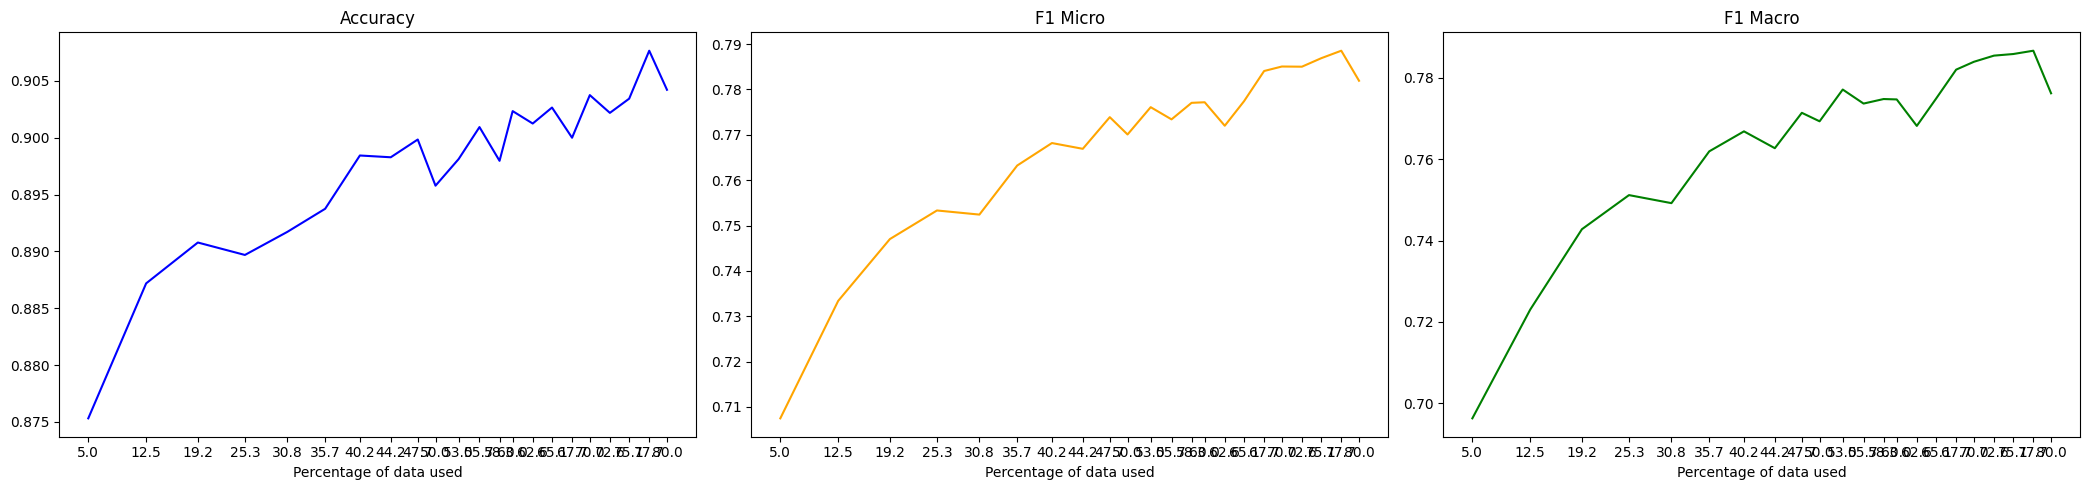

In [23]:
active_learning(seeds[4], 4)